<a href="https://colab.research.google.com/github/thatguyandy27/Pytorch-Tutorials/blob/main/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# CIFAR10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((.5, .5, .5), (.5, .5, .5))]
)

batch_size = 4
#load set, create loader for train
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#load test set, create loader for test
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

classes=('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog' ,'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [5]:
def imgshow(img):
  img = img / 2 + .5 # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

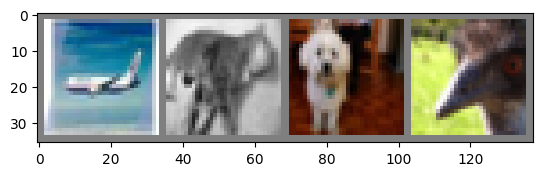

plane cat   dog   bird 


In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

imgshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [8]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    # call the first conv layer with relu activation.
    # max pool
    x = self.pool(F.relu(self.conv1(x)))
    # call second layer with relu activation and max pool!
    x = self.pool(F.relu(self.conv2(x)))
    # call flatten dimensions for fully connected layers
    x = torch.flatten(x, 1)
    # relu activation with fully connected layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    return self.fc3(x)


In [22]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=.001, momentum=.9)

In [23]:
for epoch in range(5):
  running_loss = 0

  for i, data in enumerate(trainloader, 0):
    inputs, labels = data

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if i % 2000 == 1999:
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
      running_loss = 0

print('Finished Training!')

[1,  2000] loss: 2.230
[1,  4000] loss: 1.897
[1,  6000] loss: 1.690
[1,  8000] loss: 1.606
[1, 10000] loss: 1.550
[1, 12000] loss: 1.481
[2,  2000] loss: 1.409
[2,  4000] loss: 1.358
[2,  6000] loss: 1.369
[2,  8000] loss: 1.338
[2, 10000] loss: 1.327
[2, 12000] loss: 1.288
[3,  2000] loss: 1.230
[3,  4000] loss: 1.223
[3,  6000] loss: 1.208
[3,  8000] loss: 1.206
[3, 10000] loss: 1.211
[3, 12000] loss: 1.185
[4,  2000] loss: 1.113
[4,  4000] loss: 1.133
[4,  6000] loss: 1.114
[4,  8000] loss: 1.133
[4, 10000] loss: 1.126
[4, 12000] loss: 1.127
[5,  2000] loss: 1.051
[5,  4000] loss: 1.049
[5,  6000] loss: 1.061
[5,  8000] loss: 1.044
[5, 10000] loss: 1.050
[5, 12000] loss: 1.075
Finished Training!


In [24]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

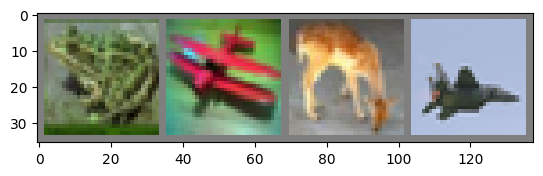

GroundTruth:  frog  plane deer  plane


In [25]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imgshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [26]:
net =Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [27]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  frog  car   cat   plane


In [28]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 59 %


In [30]:
# find classes that performed well, and what didnt'

correct_pred = { classname: 0 for classname in classes}
total_pred = { classname:0 for classname in classes}

with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predictions = torch.max(outputs, 1)
    for label, pred in zip(labels, predictions):
      if label == pred:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1


for classname, correct, in correct_pred.items():
  acc = 100.0 * correct / total_pred[classname]
  print(f'Accuracy for class: {classname:5s} is {acc:.1f} %')

Accuracy for class: plane is 70.2 %
Accuracy for class: car   is 73.0 %
Accuracy for class: bird  is 42.2 %
Accuracy for class: cat   is 65.0 %
Accuracy for class: deer  is 50.6 %
Accuracy for class: dog   is 35.3 %
Accuracy for class: frog  is 60.0 %
Accuracy for class: horse is 70.8 %
Accuracy for class: ship  is 69.3 %
Accuracy for class: truck is 55.8 %
